**Object Detection Project**

In [ ]:
!pip install -q git+https://github.com/huggingface/transformers.git


  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 49.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 78.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 31.3 MB/s eta 0:00:00


In [ ]:
!pip install Pillow
!pip install matplotlib
!pip install opencv-python


In [ ]:
from transformers.utils import send_example_telemetry

send_example_telemetry("zeroshot_object_detection_with_owlvit_notebook", framework="pytorch")


In [ ]:
from transformers import OwlViTProcessor, OwlViTForObjectDetection

model = OwlViTForObjectDetection.from_pretrained("google/owlvit-base-patch32")
processor = OwlViTProcessor.from_pretrained("google/owlvit-base-patch32")


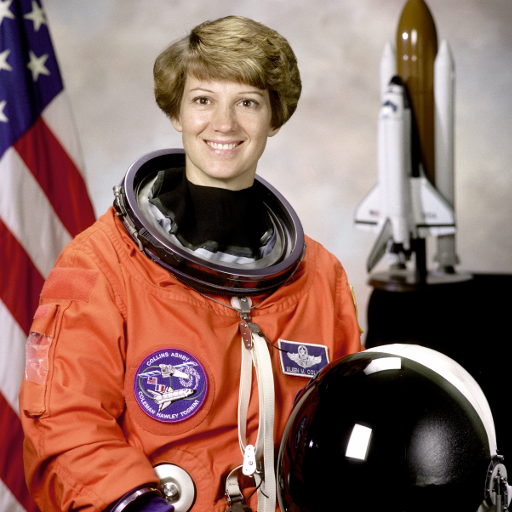

In [ ]:
import cv2
import skimage
import numpy as np
from PIL import Image

# Download sample image
image = skimage.data.astronaut()
image = Image.fromarray(np.uint8(image)).convert("RGB")

# Text queries to search the image for
text_queries = ["human face", "rocket", "nasa badge", "star-spangled banner"]

image


In [ ]:
import torch

# Use GPU if available
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")


In [ ]:
# Process image and text inputs
inputs = processor(text=text_queries, images=image, return_tensors="pt").to(device)

# Print input names and shapes
for key, val in inputs.items():
    print(f"{key}: {val.shape}")


input_ids: torch.Size([4, 16])
attention_mask: torch.Size([4, 16])
pixel_values: torch.Size([1, 3, 768, 768])


In [ ]:
# Set model in evaluation mode
model = model.to(device)
model.eval()

# Get predictions
with torch.no_grad():
  outputs = model(**inputs)

for k, val in outputs.items():
    if k not in {"text_model_output", "vision_model_output"}:
        print(f"{k}: shape of {val.shape}")

print("\nText model outputs")
for k, val in outputs.text_model_output.items():
    print(f"{k}: shape of {val.shape}")

print("\nVision model outputs")
for k, val in outputs.vision_model_output.items():
    print(f"{k}: shape of {val.shape}")


logits: shape of torch.Size([1, 576, 4])
pred_boxes: shape of torch.Size([1, 576, 4])
text_embeds: shape of torch.Size([1, 4, 512])
image_embeds: shape of torch.Size([1, 24, 24, 768])
class_embeds: shape of torch.Size([1, 576, 512])

Text model outputs
last_hidden_state: shape of torch.Size([4, 16, 512])
pooler_output: shape of torch.Size([4, 512])

Vision model outputs
last_hidden_state: shape of torch.Size([1, 577, 768])
pooler_output: shape of torch.Size([1, 768])


In [ ]:
import matplotlib.pyplot as plt

from transformers.image_utils import ImageFeatureExtractionMixin
mixin = ImageFeatureExtractionMixin()

# Load example image
image_size = model.config.vision_config.image_size
image = mixin.resize(image, image_size)
input_image = np.asarray(image).astype(np.float32) / 255.0

# Threshold to eliminate low probability predictions
score_threshold = 0.1

# Get prediction logits
logits = torch.max(outputs["logits"][0], dim=-1)
scores = torch.sigmoid(logits.values).cpu().detach().numpy()

# Get prediction labels and boundary boxes
labels = logits.indices.cpu().detach().numpy()
boxes = outputs["pred_boxes"][0].cpu().detach().numpy()


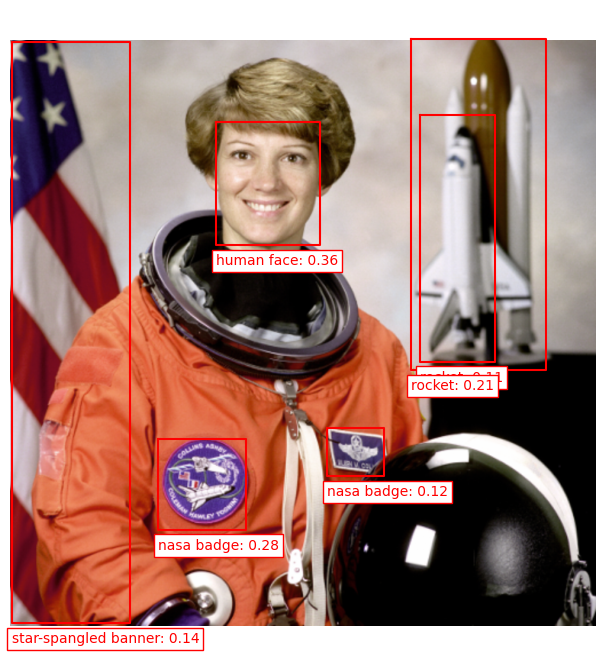

In [ ]:
def plot_predictions(input_image, text_queries, scores, boxes, labels):
    fig, ax = plt.subplots(1, 1, figsize=(8, 8))
    ax.imshow(input_image, extent=(0, 1, 1, 0))
    ax.set_axis_off()

    for score, box, label in zip(scores, boxes, labels):
      if score < score_threshold:
        continue

      cx, cy, w, h = box
      ax.plot([cx-w/2, cx+w/2, cx+w/2, cx-w/2, cx-w/2],
              [cy-h/2, cy-h/2, cy+h/2, cy+h/2, cy-h/2], "r")
      ax.text(
          cx - w / 2,
          cy + h / 2 + 0.015,
          f"{text_queries[label]}: {score:1.2f}",
          ha="left",
          va="top",
          color="red",
          bbox={
              "facecolor": "white",
              "edgecolor": "red",
              "boxstyle": "square,pad=.3"
          })

plot_predictions(input_image, text_queries, scores, boxes, labels)


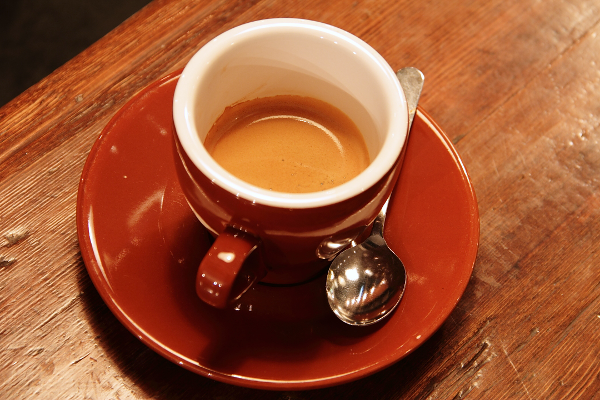

In [ ]:
# Download the coffee mug image
image = skimage.data.coffee()
image = Image.fromarray(np.uint8(image)).convert("RGB")
image


In [ ]:
# Preprocessing
images = [skimage.data.astronaut(), skimage.data.coffee()]
images = [Image.fromarray(np.uint8(img)).convert("RGB") for img in images]

# Nexted list of text queries to search each image for
text_queries = [["human face", "rocket", "nasa badge", "star-spangled banner"], ["coffee mug", "spoon", "plate"]]

# Process image and text inputs
inputs = processor(text=text_queries, images=images, return_tensors="pt").to(device)

# Print input names and shapes
for key, val in inputs.items():
    print(f"{key}: {val.shape}")


input_ids: torch.Size([8, 16])
attention_mask: torch.Size([8, 16])
pixel_values: torch.Size([2, 3, 768, 768])


In [ ]:
# Get predictions
with torch.no_grad():
  outputs = model(**inputs)

for k, val in outputs.items():
    if k not in {"text_model_output", "vision_model_output"}:
        print(f"{k}: shape of {val.shape}")

print("\nText model outputs")
for k, val in outputs.text_model_output.items():
    print(f"{k}: shape of {val.shape}")

print("\nVision model outputs")
for k, val in outputs.vision_model_output.items():
    print(f"{k}: shape of {val.shape}")


logits: shape of torch.Size([2, 576, 4])
pred_boxes: shape of torch.Size([2, 576, 4])
text_embeds: shape of torch.Size([2, 4, 512])
image_embeds: shape of torch.Size([2, 24, 24, 768])
class_embeds: shape of torch.Size([2, 576, 512])

Text model outputs
last_hidden_state: shape of torch.Size([8, 16, 512])
pooler_output: shape of torch.Size([8, 512])

Vision model outputs
last_hidden_state: shape of torch.Size([2, 577, 768])
pooler_output: shape of torch.Size([2, 768])


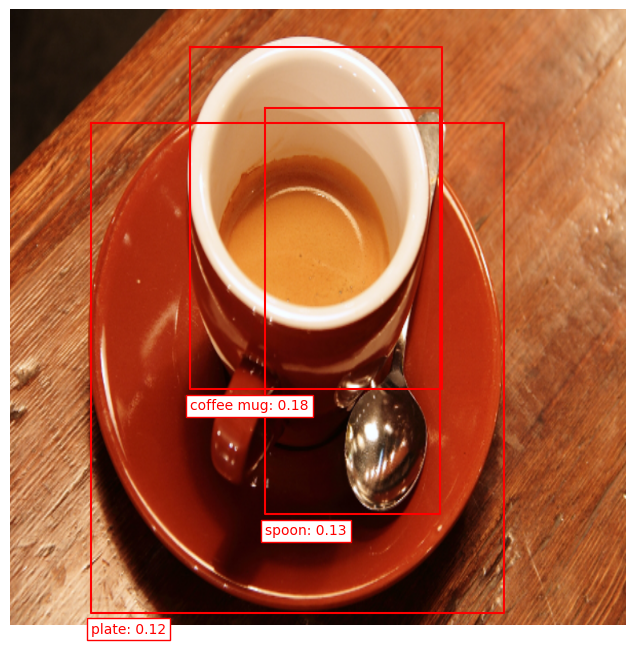

In [ ]:
# Let's plot the predictions for the second image
image_idx = 1
image_size = model.config.vision_config.image_size
image = mixin.resize(images[image_idx], image_size)
input_image = np.asarray(image).astype(np.float32) / 255.0

# Threshold to eliminate low probability predictions
score_threshold = 0.1

# Get prediction logits
logits = torch.max(outputs["logits"][image_idx], dim=-1)
scores = torch.sigmoid(logits.values).cpu().detach().numpy()

# Get prediction labels and boundary boxes
labels = logits.indices.cpu().detach().numpy()
boxes = outputs["pred_boxes"][image_idx].cpu().detach().numpy()

plot_predictions(input_image, text_queries[image_idx], scores, boxes, labels)
